# Nengoによる神経シミュレーション

Nengoはネットワークレベルでの神経シミュレーションが出来るライブラリです。

応用として、SPA(またはSpaun)という認知モデルが有名です。

PCにインストールしてGUIを使うことも出来ますが、今回はGoogleColab上のCUIで行います。

順番に Shift + Enter を押していくだけで、シミュレーションが可能です。

参考文献

１．Nengo公式ドキュメント　https://www.nengo.ai/nengo/v2.8.0/index.html

２．Nengoの使い方①～③　http://system-medicine.blog.jp/archives/7015961.html

## インストール

In [1]:
!pip install nengo

     |████████████████████████████████| 378kB 3.3MB/s 


これで、GoogleColab上でNengoが使えるようになりました。(制限時間12時間)

次からは、デモを行います。

## デモ１　神経回路のダイナミクス
ここではカオス理論のローレンツ方程式で記述されるダイナミクスを持つ神経ネットワークを作成してみる。


In [10]:
import nengo

In [15]:
# モデルの定義（100個の神経細胞で構成され、3変数を出力するネットワーク）
tau = 0.1
sigma = 10
beta = 8.0 / 3
rho = 28

def feedback(x):
    dx0 = -sigma * x[0] + sigma * x[1]
    dx1 = -x[0] * x[2] - x[1]
    dx2 = x[0] * x[1] - beta * (x[2] + rho) - rho
    return [dx0 * tau + x[0], dx1 * tau + x[1], dx2 * tau + x[2]]

model = nengo.Network(label='Lorenz attractor')
with model:
    state = nengo.Ensemble(100, 3, radius=30)
    nengo.Connection(state, state, function=feedback, synapse=tau)
    state_probe = nengo.Probe(state, synapse=tau)
    spike_probe = nengo.Probe(state.neurons)

In [16]:
# シミュレーション実行
with nengo.Simulator(model) as sim:
    sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

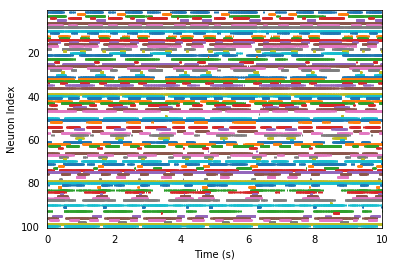

In [17]:
# スパイクのラスタープロット
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
rasterplot(sim.trange(), sim.data[spike_probe])
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index');

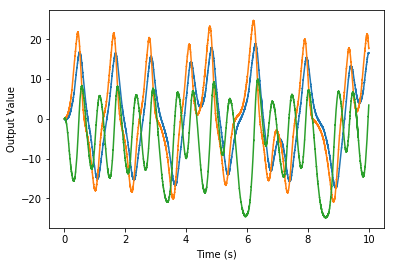

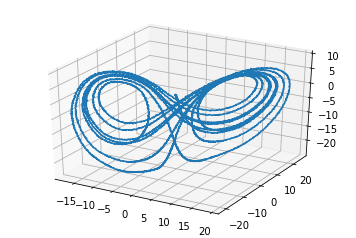

In [18]:
# ダイナミクスのプロット
from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.plot(sim.trange(), sim.data[state_probe])
plt.xlabel('Time (s)')
plt.ylabel('Output Value');
ax = plt.figure().add_subplot(111, projection='3d')
ax.plot(*sim.data[state_probe].T)

## デモ２ SPAによる認知モデル
SPAによる認知モデルを使って、神経回路に２つの語句の組み合わせを覚えさせます。

まずは、'One'と'Uno'など対になる語句(ここでは英語とスペイン語)を入力していきます。 

その後に片方の語句を入力すると、もう片方のものを思い出して出力するようになります。

In [7]:
import nengo
from nengo import spa

In [8]:
# モデルの定義
model = spa.SPA(label="Question answering")
dimensions = 32
with model:
    model.English_in = spa.State(dimensions=dimensions)
    model.Spanish_in = spa.State(dimensions=dimensions)
    model.conv = spa.State(dimensions=dimensions,
                           neurons_per_dimension=100,
                           feedback=1,
                           feedback_synapse=0.4)
    model.cue = spa.State(dimensions=dimensions)
    model.out = spa.State(dimensions=dimensions)

    # Connect the state populations
    cortical_actions = spa.Actions(
        'conv = English_in * Spanish_in',
        'out = conv * ~cue'
    )
    model.cortical = spa.Cortical(cortical_actions)

In [9]:
# 入力の設定
input_time = 0.5
def English_input(t):
    if t < input_time:
        return 'One'
    elif t < 2*input_time:
        return 'Two'
    else:
        return '0'


def Spanish_input(t):
    if t < input_time:
        return 'Uno'
    elif t < 2*input_time:
        return 'Dos'
    else:
        return '0'


def cue_input(t):
    if t < 2*input_time:
        return '0'
    sequence = ['0', 'Uno', 'One', '0', 'Dos', 'Two']
    idx = int(((t - 2*input_time) // (1. / len(sequence))) % len(sequence))
    return sequence[idx]

with model:
    model.inp = spa.Input(English_in=English_input, Spanish_in=Spanish_input, cue=cue_input)

In [10]:
# 出力の設定
with model:
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    English_in = nengo.Probe(model.English_in.output)
    Spanish_in = nengo.Probe(model.Spanish_in.output)
    cue = nengo.Probe(model.cue.output)
    conv = nengo.Probe(model.conv.output)
    out = nengo.Probe(model.out.output)

In [11]:
# シミュレーション実行
with nengo.Simulator(model) as sim:
    sim.run(5.)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

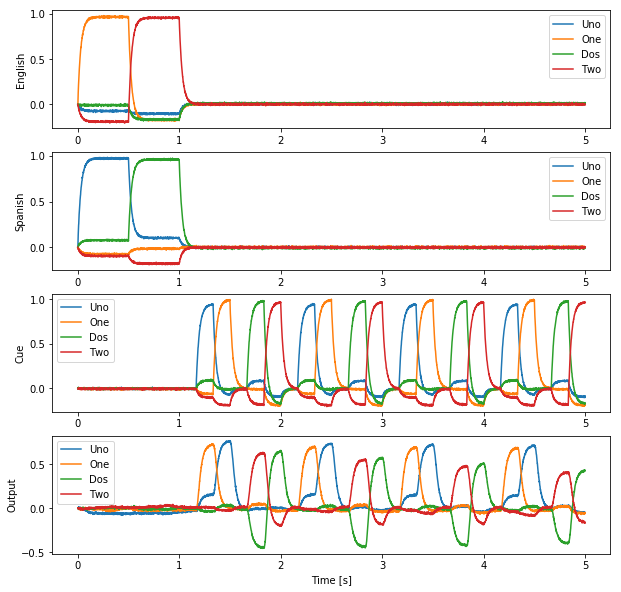

In [12]:
# プロット
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
vocab = model.get_default_vocab(dimensions)

plt.subplot(4, 1, 1)
plt.plot(sim.trange(), model.similarity(sim.data, English_in))
plt.legend(model.get_output_vocab('English_in').keys)
plt.ylabel("English")

plt.subplot(4, 1, 2)
plt.plot(sim.trange(), model.similarity(sim.data, Spanish_in))
plt.legend(model.get_output_vocab('Spanish_in').keys)
plt.ylabel("Spanish")

plt.subplot(4, 1, 3)
plt.plot(sim.trange(), model.similarity(sim.data, cue))
plt.legend(model.get_output_vocab('cue').keys)
plt.ylabel("Cue")

plt.subplot(4, 1, 4)
plt.plot(sim.trange(), spa.similarity(sim.data[out], vocab))
plt.legend(model.get_output_vocab('out').keys)
plt.ylabel("Output")
plt.xlabel("Time [s]");

最初の一秒間は両方を提示して記憶をさせて、その後に片方を提示して想起させている。

3段目と4段目の図を見て、Cueで入力されている文字に対して、対訳になる文字がOutputで上昇していることが分かる。